# Hands-on: Scalable Gaussian Process Regression with Stan

## Objectives
In this tutorial, you will learn about how to implement an fast and scalable Gaussian Process (GP) approximation in Stan. More specificially, this tutorial will teach you how to implement the Hilbert space approximate Gaussian process (HSGP) proposed by Arno Solin and Simo Sarkkar in 2020 [1] and picked up by Riutort-Mayol et al. (2022) [2] for use in probabilistic programming frameworks such as Stan.

1. Arno Solin and Simo Sarkka (2020). Hilber space methods for reduced-rank Gaussian process regression. *Statistics and Computing*.
2. Gabriel Riutort-Mayol et al. (2022), Practical Hilbert space approximate Gaussian processes for probabilistic programming. *Statistics and Computing*.

By the end of this tutorial, 
1. You will have a better understanding of implementing custom functions in Stan;
2. You will improve your ability to translate mathematics into Stan code;
3. You will have a better understanding of HSGP and its implementation in Stan.

## Flow of the tutorial
1. Brief description of the dataset
2. Review of Gaussian Processes
3. How to implement a GP in Stan
4. Review of Hilbert Space approximate Gaussian Processes
5. How to implement HSGP in Stan

In [ ]:
import numpy as np
import pandas as pd

from cmdstanpy import CmdStanModel
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation defaults
sns.set_theme(style='whitegrid')
plt.rc('font', size=9)          # controls default text sizes
plt.rc('axes', titlesize=10)    # fontsize of the axes title
plt.rc('axes', labelsize=9)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=9)    # legend fontsize

: 

## The dataset
For this tutorial, we will use the `nile` dataset available via the `statsmodels` library. The dataset consists of annual flow measurements of the Nile River at Aswan from 1871 to 1970.

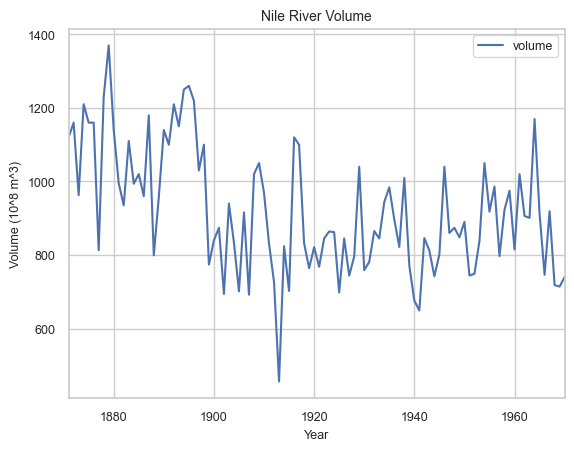

In [3]:
from statsmodels.datasets import nile
nile = nile.load_pandas().data

# Plot the data
fig, ax = plt.subplots()
nile.plot(x='year', y='volume', ax=ax)
ax.set_title('Nile River Volume')
ax.set_xlabel('Year')
ax.set_ylabel('Volume (10^8 m^3)')
ax.set_xlim(1871, 1970)
plt.show()

### Data preprocessing
To make things easier for the model, we will normalise the year data to be between 0 and 1 and standardise the flow data to have a mean of 0 and a standard deviation of 1.

In [4]:
volume = nile['volume'].values
year = nile['year'].values

# Standardise year
year_mean = year.mean()
year_std = year.std()
x = (year - year_mean) / year_std

# Standardise volume
volume_mean = volume.mean()
volume_std = volume.std()
y = (volume - volume_mean) / volume_std

print(x.shape, y.shape)

(100,) (100,)


## Review of Gaussian Process Regression

Let $\mathbf{y} = (y_1,\ldots,y_n)^\top$ be a vector of outcomes, in this case flow volume. Let $\mathbf{x} = (x_1,\ldots,x_n)^\top$ be a vector of inputs, in this case year. We will model the data as
$$
\begin{align*}
\mathbf{y} &= \alpha + f(\mathbf{x}) + \boldsymbol{\varepsilon}, \\
f(\mathbf{x}) &\sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x},\mathbf{x}')), \\
\boldsymbol{\varepsilon} &\sim \mathcal{N}(0, \sigma_{\varepsilon}^2\mathbf{I}_n),
\end{align*}
$$
where $m(\mathbf{x})$ is the mean function, $k(\mathbf{x},\mathbf{x}')$ is the covariance function, and $\sigma_{\varepsilon}^2$ is the noise variance. For simplicity, we will assume that $m(\mathbf{x}) = 0$
$$
f(\mathbf{x}) \sim \mathcal{GP}(0, k(\mathbf{x},\mathbf{x}')).
$$

Recall that for finite data, the zero mean GP prior is a multivariate Gaussian distribution with mean vector $\mathbf{0}$ and covariance matrix $\mathbf{K}$, where $K_{ij} = k(x_i,x_j)$. 
$$
\mathbf{K} = \begin{pmatrix}
k(x_1,x_1) & \cdots & k(x_1,x_n) \\
\vdots & \ddots & \vdots \\
k(x_n,x_1) & \cdots & k(x_n,x_n)
\end{pmatrix}.
$$

The function $k$ is referred to as a covariance function or kernel function. Common choices for the kernel function include the squared exponential kernel, the Matern kernel, and the periodic kernel. As we shall see later, the choice of kernel characterises the smoothness of the GP. If, for example, we chose the squared exponential kernel, then $k$ has the form
$$
k(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\ell^2}\right),
$$
where $\sigma^2$ is the marginal variance and $\ell$ is the lengthscale.

To sample from a GP, we first compute the covariance matrix $\mathbf{K}$ for a given set of inputs $\mathbf{x}$, kernel $k$, and hyperparameters. We then perform the Cholesky decomposition of $\mathbf{K}$ such that
$$
\mathbf{K} = \mathbf{L}\mathbf{L}^\top,
$$
where $\mathbf{L}$ is a lower triangular matrix. We then sample an auxiliary vector $\mathbf{z}$ from a standard multivariate normal distribution, i.e., $\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I}_n)$. Finally, we compute the GP sample as
$$
\mathbf{f} = \mathbf{L}\mathbf{z}.
$$

## Implementing a GP in Stan

### The GP prior
To keep the code in the other blocks clean, we will define the GP prior in the `functions` block. We will write a custom function named `gp_se` that takes in the input points `x`, the marginal variance `alpha`, and the lengthscale `ell`, and a vector of auxiliary variables `z`. The function will return the GP sample `f`. The code will look something like this:

```stan
functions {
	vector gp_se(vector x, real sigma, real ell, vector z) {
		int n = rows(x);
		matrix[n,n] K;
		vector[n] f;
		matrix[n,n] L;

		// 1. Compute the covariance matrix (don't forget to add the nuggget term)

		// 2. Perform the Cholesky decomposition

		// 3. Compute the GP sample

		return f;
	}
}
```

Your task is to fill in the missing parts of the code. Refer to the [Stan Functions Reference](https://mc-stan.org/docs/functions-reference/index.html) on how to compute the covariance matrix, how to construct an identity matrix (for the nugget term), and on how to perform the Cholesky decomposition.

### The data block
In the data block, we will declare the number of data points `N`, input points `x` and the outcome `y`. Do you remember how to do this?

### The parameters block
In the parameters block, we need to declare the hyperparameters of the GP, namely the marginal variance $\sigma$ and the lengthscale $\ell$. We also need to declare the auxiliary variables $\mathbf{z}$ and the noise variance $\sigma_\varepsilon$.

### Transformed parameters block
In the transformed parameters block, we will compute the GP sample `f` using the custom function `gp_se` that we defined earlier.

### The model block
In the model block, we specify the likelihood and the priors for each parameter and the auxiliary random variables. We will assume a normal likelihood for the data and inverse-gamma priors for the hyperparameters. We will also assume an inverse-gamma prior for the noise variance.
$$
\begin{align*}
y_i &\sim \mathcal{N}(f_i, \sigma_{\varepsilon}^2), \\
\sigma^2 &\sim \text{inv-Gamma}^+(1,5), \\
\ell^2 &\sim \text{inv-Gamma}^+(1,5), \\
\sigma^2_{\varepsilon} &\sim \text{inv-Gamma}^+(1,5) \\
z_i &\sim \mathcal{N}(0, 1).
\end{align*}
$$
In case you are wondering, below is a plot of the density of the inverse-gamma distribution with shape parameter 1 and scale parameter 5.

In [ ]:
from scipy import stats

# Parameters for the inverse-gamma distribution
alpha = 1  # shape parameter
beta = 5   # scale parameter

# Generate x values
x_vals = np.linspace(0.1, 20, 1000)  # avoiding x=0 as PDF is undefined there

# Calculate PDF
pdf = stats.invgamma.pdf(x_vals, alpha, scale=beta)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, pdf, 'b-', lw=2)
plt.title('Inverse-Gamma Distribution (α=1, β=5)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlim(0, 20)
plt.show()

: 

### Generated quantities block
Finally, in the generated quantities block, we will compute the log likelihood for each data point (for model comparison) and the predicted values for the input points.

### Compiling and running the Stan program
Recall that to compile the Stan program, we use the `CmdStanModel` class from the `cmdstanpy` library. You will need to specify the path to your `.stan` file. After compiling the model, you need to prepare the data as a dictionary and pass it to the `CmdStanModel` object's `sample` method.

In [5]:
gp_model = CmdStanModel(stan_file='stan/gp_regression.stan')

In [6]:
stan_data = {
	'N': len(x),
	'x': x,
	'y': y,
}

In [7]:
import time

start_time = time.time()

gp_fit = gp_model.sample(
    data=stan_data,
    chains=4,
    iter_warmup=500,
    iter_sampling=1000,
    adapt_delta=0.95,
    seed=0)

end_time = time.time()
runtime = end_time - start_time
print(f"Runtime of the Stan model: {runtime} seconds")

13:44:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:46:27 - cmdstanpy - INFO - CmdStan done processing.
13:46:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in 'gp_regression.stan', line 9, column 2 to column 72) (in 'gp_regression.stan', line 43, column 1 to column 39)
	Exception: Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in 'gp_regression.stan', line 9, column 2 to column 72) (in 'gp_regression.stan', line 43, column 1 to column 39)
	Exception: Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in 'gp_regression.stan', line 9, column 2 to column 72) (in 'gp_regression.stan', line 43, column 1 to column 39)
	Exception: Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in 'gp_regression.stan', line 9, column 2 to column 72) (in 'gp_regression.stan', line 43, column 1 to column 39)
	Exception: Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in 'gp_regression.stan', line 9, column 2 to colu

13:46:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Runtime of the Stan model: 128.71517205238342 seconds


How long did it take the inference algorithm to run?

### Posthoc model diagnostics
We should always check for issues in the sampling process and whether the MCMC chains have converged. We can use the `CmdStanMCMC` object's `diagnose` method to check for divergences, treedepth issues, and other potential problems. We can also use the `CmdStanMCMC` object's `summary` method to get a summary of the posterior samples.

In [8]:
print(gp_fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
13 of 1000 (1.30%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete.



In [9]:
gp_fit_summary = gp_fit.summary()
filtered_params = gp_fit_summary[(gp_fit_summary['R_hat'] > 1.01) & (gp_fit_summary['ESS_bulk'] < 1000)]
filtered_params

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat


### Posterior analysis

In [10]:
idata_gp = az.from_cmdstanpy(gp_fit)

In [11]:
custom_summary_fns = {
	'median': lambda x: np.percentile(x, 50),
	'q2.5': lambda x: np.percentile(x, 2.5),
	'q97.5': lambda x: np.percentile(x, 97.5),
}

mu_sum_gp = az.summary(idata_gp, var_names=['mu'], stat_funcs=custom_summary_fns, extend=False)

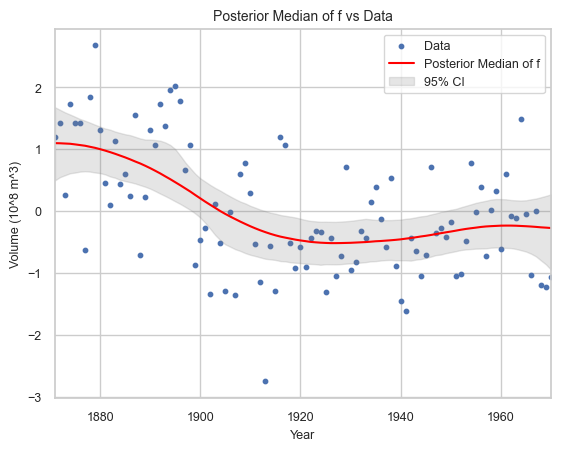

In [12]:
def plot_posterior_summary(year, y, posterior_summary):
	fig, ax = plt.subplots()
	ax.scatter(year, y, label='Data', s=10)
	ax.plot(year, posterior_summary['median'], label='Posterior Median of f', color='red')
	ax.fill_between(year, posterior_summary['q2.5'], posterior_summary['q97.5'], color='gray', alpha=0.2, label='95% CI')
	ax.set_title('Posterior Median of f vs Data')
	ax.set_xlabel('Year')
	ax.set_ylabel('Volume (10^8 m^3)')
	ax.set_xlim(1871, 1970)
	ax.legend()
	plt.show()

# Example usage:
plot_posterior_summary(year, y, mu_sum_gp)

### Posterior predictive checks

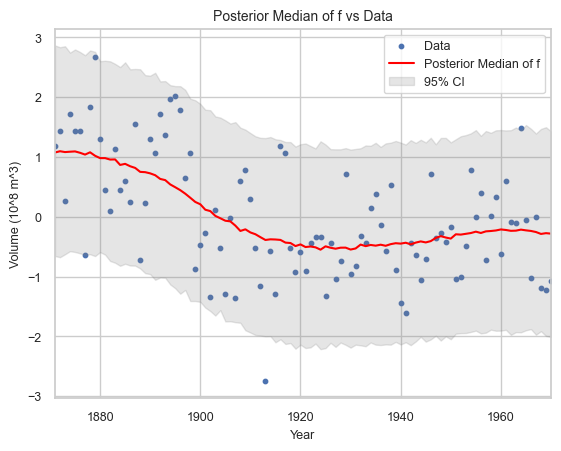

In [13]:
y_rep_sum = az.summary(idata_gp, var_names=['y_rep'], stat_funcs=custom_summary_fns, extend=False)
plot_posterior_summary(year, y, y_rep_sum)

In [14]:
# Calculate the proportion of points within the 95% CI
within_ci = ((y >= y_rep_sum['q2.5']) & (y <= y_rep_sum['q97.5'])).mean()
print(f"Proportion of points within the 95% CI: {within_ci:.2f}")

Proportion of points within the 95% CI: 0.98
